# Best Practices - Feature Engineering

This notebook walks through recommended feature engineering techniques that can be used to improve model performance.

**Steps**

1. Import and clean data
2. Train baseline model
3. Convert text features to word-embeddings
4. Perform target encoding on categorical features
5. Add anomaly score
6. Evaluate improvement to model
7. Analyze final model

## Step 1. Import and Clean Data

We will start by importing the raw lending club data into our H2O-3 cluster.

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [2]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [3]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o


Checking whether there is an H2O instance running at http://localhost:38097..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa4ix23d8
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa4ix23d8/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmpa4ix23d8/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:38097
Connecting to H2O server at http://127.0.0.1:38097... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,"14 days, 19 hours and 12 minutes"
H2O cluster name:,H2O_from_python_bear_oabidw
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [4]:
data_path = "data/LoanStats3a.csv"
data = h2o.import_file(data_path, destination_frame = "loan_raw")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
data.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.0775e+06,1.2966e+06,5000,5000,4975,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01 00:00:00,1,,,3,0,13648,83.7%,9,f,0,0,5861.07,5831.78,5000,861.07,0,0,0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0,,1
1.07743e+06,1.31417e+06,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000,VERIFIED - income source,2011-12-01 00:00:00,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces,car,bike,309xx,GA,1,0,1999-04-01 00:00:00,5,,,3,0,1687,9.4%,4,f,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,2013-04-01 00:00:00,119.66,,2013-09-01 00:00:00,0,,1
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1
1.07686e+06,1.27718e+06,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",other,personel,917xx,CA,20,0,1996-02-01 00:00:00,1,35,,10,0,5598,21%,37,f,0,0,12226.3,12226.3,10000,2209.33,16.97,0,0,2015-01-01 00:00:00,357.48,,2015-01-01 00:00:00,0,,1
1.07536e+06,1.31175e+06,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,VERIFIED - income source,2011-12-01 00:00:00,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it.",other,Personal,972xx,OR,17.94,0,1996-01-01 00:00:00,0,38,,15,0,27783,53.9%,38,f,1168.04,1168.04,2767.64,2767.64,1831.96,935.68,0,0,0,2015-06-01 00:00:00,67.79,2015-07-01 00:00:00,2015-06-01 00:00:00,0,,1
1.07527e+06,1.31144e+06,5000,5000,5000,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanD

Our dataset is still in the raw form.  We will first need to create our target variable which indicates if the loan was fully paid off.  There are, however, loans that are still currently being paid off.  We will want to remove these loans from our data since we do not know if they will be fully paid off or not in the future.

In [6]:
data["loan_status"].table()

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


In [7]:
# Drop all loans that are still in progess and therefore cannot be deemed good/bad loans
to_remove = ["Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
data = data[data["loan_status"].isin(to_remove).logical_negation(), :]

In [8]:
# Make target column
data["bad_loan"] = (data["loan_status"] == "Fully Paid").logical_negation()
data["bad_loan"] = data["bad_loan"].asfactor()

Now we have a binary target column called `bad_loan` indicate if the loan was not fully paid off.

In [9]:
data["bad_loan"].table()

bad_loan,Count
0,30843
1,8194


We will now do some data cleaning.  The columns `revol_util` and `emp_length` are being treated as categoricals instead of numeric because the unit of measure is included.  Machine learning algorithms will treat this as a categorical and will not understand that 8 years is closer to 9 years than 1 year.  To recitify this, we will use H2O to remove the units of measure and convert the column to numeric.

In [10]:
data[["revol_util", "emp_length"]]

revol_util,emp_length
83.7%,10+ years
9.4%,< 1 year
98.5%,10+ years
21%,10+ years
28.3%,3 years
87.5%,9 years
32.6%,4 years
36.5%,< 1 year
20.6%,5 years
67.1%,10+ years


In [11]:
# Data cleaning of revol_util

data["revol_util"] = data["revol_util"].gsub(pattern = "%", replacement = "")
data["revol_util"] = data["revol_util"].trim() 
data["revol_util"] = data["revol_util"].asnumeric() 
data["revol_util"].show()

revol_util
943
1012
1105
191
277
981
336
381
187
744


In [12]:
# Data cleaning of emp_length
data["emp_length"] = data["emp_length"].ascharacter()
data["emp_length"] = data["emp_length"].gsub(pattern = "([ ]*+[a-zA-Z].*)|(n/a)", replacement = "") 
data["emp_length"] = data["emp_length"].trim()
data["emp_length"] = data["emp_length"].gsub(pattern = "< 1", replacement = "0")
data["emp_length"] = data["emp_length"].gsub(pattern = "10\\+", replacement = "10")
data["emp_length"] = data["emp_length"].asnumeric()
data["emp_length"].show()

emp_length
10
0
10
10
3
9
4
0
5
10


Our last cleaning step will be to remove all columns that are not relevant to our use case.  Some columns we will not use because they have data leakage. Data leakage means the column has information that we will not know at the time a person applies for a loan.

In [13]:
# Filter to relevant columns
cols = ["purpose", "desc", "addr_state", "term", "emp_length", "home_ownership", "annual_inc", "dti", "delinq_2yrs", 
        "revol_util", "total_acc", "bad_loan", "issue_d", "earliest_cr_line", "verification_status"]

In [14]:
data = data[cols]
data.head()

purpose,desc,addr_state,term,emp_length,home_ownership,annual_inc,dti,delinq_2yrs,revol_util,total_acc,bad_loan,issue_d,earliest_cr_line,verification_status
credit_card,Borrower added on 12/22/11 > I need to upgrade my business technologies.,AZ,36 months,10,RENT,24000,27.65,0,943,9,0,2011-12-01 00:00:00,1985-01-01 00:00:00,VERIFIED - income
car,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces,GA,60 months,0,RENT,30000,1,0,1012,4,1,2011-12-01 00:00:00,1999-04-01 00:00:00,VERIFIED - income source
small_business,,IL,36 months,10,RENT,12252,8.72,0,1105,10,0,2011-12-01 00:00:00,2001-11-01 00:00:00,not verified
other,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",CA,36 months,10,RENT,49200,20,0,191,37,0,2011-12-01 00:00:00,1996-02-01 00:00:00,VERIFIED - income source
wedding,,AZ,36 months,3,RENT,36000,11.2,0,277,12,0,2011-12-01 00:00:00,2004-11-01 00:00:00,VERIFIED - income source
car,Borrower added on 12/16/11 > Downpayment for a car.,CA,36 months,9,RENT,48000,5.35,0,981,4,0,2011-12-01 00:00:00,2007-01-01 00:00:00,VERIFIED - income source
small_business,Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) My score is not A+ because I own my home and have no mortgage.,CA,60 months,4,OWN,40000,5.55,0,336,13,1,2011-12-01 00:00:00,2004-04-01 00:00:00,VERIFIED - income source
other,"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car. Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house.",TX,60 months,0,RENT,15000,18.08,0,381,3,1,2011-12-01 00:00:00,2004-09-01 00:00:00,VERIFIED - income
debt_consolidation,"Borrower added on 12/15/11 > I had recived a loan from Citi Financial about a year ago, I was paying 29.99 intrest, so the refinance is to cut that rate since cleaning up my credit I have been paying everything on time as shown on my credit report",AZ,60 months,5,OWN,72000,16.12,0,187,23,0,2011-12-01 00:00:00,1998-01-01 00:00:00,not verified
debt_consolidation,,CA,36 months,10,OWN,75000,10.78,0,744,34,0,2011-12-01 00:00:00,1989-10-01 00:00:00,VERIFIED - income source


## Step 2. Train Baseline Model

We will train an initial model.  The goal of our initial model is to provide a baseline AUC that we will try to beat with our feature engineering. 

We will start by splitting the data into training and testing by time.  Our testing data will consist of the last two months of data (2011/11 and 2011/12).

In [15]:
is_train = ~((data["issue_d"].year() == 2011) and (data["issue_d"].month() >= 11))

train = data[is_train == 1]
test = data[is_train == 0]

In [16]:
target = "bad_loan"
predictors = list(set(train.col_names) - set([target]))

In [17]:
# Train initial GBM model
from h2o.estimators import H2OGradientBoostingEstimator

gbm_baseline = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_baseline.hex", 
                                            ntrees = 500, 
                                            stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                            stopping_metric = "AUC",
                                            nfolds = 5 # 5-fold cross validation
                                           )
gbm_baseline.train(x = predictors, y = target, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
print("AUC on CV: " + str(round(gbm_baseline.auc(xval = True), 3)))

AUC on CV: 0.719


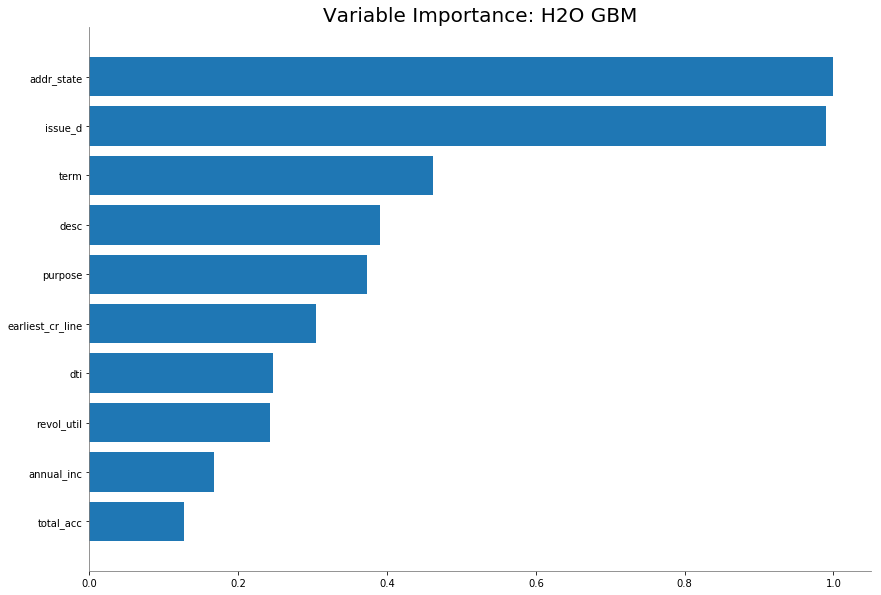

In [19]:
gbm_baseline.varimp_plot()

## Step 3. Convert Text to Word Embeddings

Our dataset has a text column called `desc`.  We will convert this string to word embeddings so that it can be more useful to our supervised learning model.

In [20]:
data["desc"]

desc
Borrower added on 12/22/11 > I need to upgrade my business technologies.
Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces
""
"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time."
""
Borrower added on 12/16/11 > Downpayment for a car.
Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) My score is not A+ because I own my home and have no mortgage.
"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car. Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house."
"Borrower added on 12/15/11 > I had recived a loan from Citi Financial about a year ago, I was paying 29.99 intrest, so the refinance is to cut that rate since cleaning up my credit I have been paying everything on time as shown on my credit report"
""


We will first examine the performance of our model if we remove the `desc` variable from the model.  

In [21]:
# Train initial GBM model
gbm_no_desc = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_baseline.hex", 
                                           ntrees = 500, 
                                           stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                           stopping_metric = "AUC",
                                           nfolds = 5 # 5-fold cross validation
                                          )
gbm_no_desc.train(x = list(set(predictors) - set(["desc"])), y = target, training_frame = train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
print("AUC on CV - Baseline: " + str(round(gbm_baseline.auc(xval = True), 3)))
print("AUC on CV - without Desc: " + str(round(gbm_no_desc.auc(xval = True), 3)))

AUC on CV - Baseline: 0.719
AUC on CV - without Desc: 0.721


The performance of our model is much better if we do not use `desc` as a predictor.  This could be because the algorithm has a hard time understanding the text. We will instead convert it to numeric vectors by using the Word2Vec algorithm.

Our first step will be to tokenize the `desc` column.  This splits the descriptions by word.  Our function will also:

* convert all words to lowercase
* remove words with numbers
* remove words with only 1 letter
* remove stop words (stop words are defined by the nltk package)

In [23]:
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
STOP_WORDS[0:5]

['i', 'me', 'my', 'myself', 'we']

In [24]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [25]:
# Break desc into sequence of words
desc = tokenize(train["desc"].ascharacter())

Now we have our the tokenized `desc`, we can train our Word2Vec model.  This will learn the word embeddings that will represent each word.

In [26]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

# This takes time to run - left commented out
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=desc)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


We can use the Word2Vec model to find synonyms.  Synonyms are defined as words with small cosine distance between their word embeddings.  Words that have similar word embeddings should have similar meanings.  

We can test the understanding of our Word2Vec model by finding synonyms for the words `wedding` and `car`.

In [27]:
# Sanity check - find synonyms for the word 'wedding'
w2v_model.find_synonyms("wedding", count = 5)

OrderedDict([('honeymoon', 0.8058181405067444),
             ('ceremony', 0.7579385638237),
             ('reception', 0.7306615114212036),
             ('venue', 0.7148143649101257),
             ('flowers', 0.7052299380302429)])

In [28]:
# Sanity check - find synonyms for the word 'car'
w2v_model.find_synonyms("car", count = 5)

OrderedDict([('prius', 0.7367169260978699),
             ('auto', 0.7254950404167175),
             ('vehicle', 0.6898690462112427),
             ('tahoe', 0.6756600141525269),
             ('chevy', 0.6553258299827576)])

Now we can add the word embeddings as new features in our data.  There are multiple words for each description so we will need to aggregate our word embeddings so that there is a single vector of word embeddings per loan.  We will do this by averaging the word embeddings using the `aggregate_method = "AVERAGE"`.

In [29]:
# Calculate a vector for each desc
train_desc_vecs = w2v_model.transform(desc, aggregate_method = "AVERAGE")

In [30]:
train_desc_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0.051485,0.0298678,-0.191229,0.154879,-0.0526432,0.0386019,0.0301266,0.239592,0.166909,-0.0344579,0.0357199,-0.0544445,-0.00240069,0.0792925,0.0403511,-0.0444389,-0.173893,-0.282712,-0.101402,-0.144146,0.162886,0.193998,0.0313054,-0.140226,0.314232,0.170582,0.269805,0.0100003,0.137856,0.0811185,-0.076493,0.0244586,-0.0724299,0.0444752,0.0353887,-0.0263754,-0.151983,0.0663266,0.0303797,0.252639,-0.174482,-0.133098,-0.10586,-0.00841798,-0.0288888,0.205538,-0.159181,-0.019627,-0.0305828,0.00401825,0.148619,-0.198437,-0.0853358,-0.109941,0.0384075,-0.0212695,0.17375,-0.311412,0.0885101,-0.0161093,0.0860277,0.0110224,-0.0272963,0.26974,-0.103293,-0.0137629,0.13608,-0.0349647,-0.0595904,0.0638347,-0.174014,0.118617,0.0161443,0.237723,0.14144,-0.0257815,-0.0910862,0.0359916,-0.0291356,-0.082513,0.0953601,-0.172926,-0.0229632,0.0609323,0.0869217,0.0445849,-0.179878,0.0115228,-0.294365,0.0832127,-0.100902,0.036608,-0.146624,-0.0322084,-0.0361164,-0.019737,-0.0565529,0.0377979,0.0391956,0.00344873
-0.0247435,-0.00345412,-0.0387461,0.0570247,0.0111559,0.0447889,-0.146599,0.104003,0.202629,-0.19627,0.042132,-0.0497085,0.0456759,-0.08616,0.0795356,0.0689691,-0.310117,-0.0996072,-0.12398,-0.0643707,0.0494289,0.188151,0.0930717,0.0752697,0.346037,0.145925,0.297809,-0.0954304,0.18664,0.140234,-0.136054,0.0500368,0.176985,-0.0402791,-0.192139,-0.122685,-0.111858,0.0507381,0.153893,0.238544,0.0125035,-0.0377817,-0.163201,-0.0490543,0.0608103,0.152608,-0.165874,-0.0128221,-0.0213045,-0.0162853,0.0973797,-0.112968,-0.128557,-0.00195039,-0.0535953,0.0894354,0.00388779,-0.107261,0.0837807,-0.22233,-0.0607478,0.0760062,-0.0141491,0.179519,-0.17633,-0.0136841,0.0276303,-0.00607329,0.0599132,0.0401342,-0.0402511,0.00733609,0.134636,0.163513,0.0843371,-0.0428041,-0.0520351,0.0279385,-0.064075,0.0290362,0.107247,-0.215349,0.0165443,-0.0270307,0.0157693,0.0106068,-0.121554,-0.00976224,-0.183343,-0.0161634,0.0308064,0.176824,-0.0780756,0.0172795,0.118937,-0.00897894,-0.0384528,-0.0496187,0.0444964,0.0269089
0.0420468,-0.00852445,-0.164501,0.0995192,0.0400135,0.0327618,-0.0010096,0.187264,0.214742,0.00120483,0.00183723,-0.0698497,0.0304956,0.0335321,0.0350048,-0.00728006,-0.228504,-0.22442,-0.197575,-0.177928,0.0802895,0.212112,0.0962902,-0.0877248,0.271526,0.183337,0.21304,-0.0422453,0.108149,0.164954,-0.0542541,0.0432352,-0.0748903,0.0671117,0.0372047,0.00706794,-0.0978306,0.0219846,-0.0298402,0.130788,-0.119137,-0.0708701,-0.125623,-0.0281574,-0.0385592,0.206474,-0.154879,-0.01896,0.0193065,0.0237693,0.0772381,-0.179355,-0.0455756,-0.0375914,-0.0303199,0.00288408,0.128632,-0.246131,0.0309093,-0.0758558,0.0195414,0.0324733,0.0771917,0.199171,-0.113603,-0.0204171,0.0603625,0.00129327,-0.0190886,0.021108,-0.153672,0.195392,0.065823,0.182397,0.221101,0.0502726,-0.0278748,0.0666464,-0.16796,-0.0639937,0.110325,-0.146315,-0.0370396,0.0369935,-0.0136186,0.00730649,-0.181719,0.0626666,-0.220821,0.0412077,-0.087644,-0.091182,-0.215788,-0.0170467,-0.0290061,0.0100414,-0.0559593,0.0566027,-0.000316831,-0.0209971
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.0196599,0.0214039,-0.162288,0.19203,-0.00126662,0.0462967,-0.0738191,0.108453,0.182445,-0.0132184,0.160048,-0.0729019,0.0095077,0.0714731,-0.0268082,-0.0911548,-0.2772,-0.18390

In [31]:
# Add aggregated word embeddings 
ext_train = train.cbind(train_desc_vecs)

The word embeddings have added 100 columns to our data.

In [32]:
print("Number of columns in original data: " + str(train.ncol))
print("Number of columns with word embeddings: " + str(ext_train.ncol))

Number of columns in original data: 15
Number of columns with word embeddings: 115


We will also add the word embeddings to our test data.  We have trained our Word2Vec model on the train data only.  This is not necessary since we are training an unsupervised learning model on the `desc` column only so there should be limited data leakage.  By building a Word2Vec model on the train data and applying this model to the test data, however, we are most closely mimicking how this process will be done in production.

In [33]:
test_desc = tokenize(test["desc"].ascharacter())
test_desc_vecs = w2v_model.transform(test_desc, aggregate_method="AVERAGE")
ext_test = test.cbind(test_desc_vecs)

We will now train our model with word embeddings as new features in replace of `desc`.

In [34]:
# Train GBM model with word embeddings

predictors = list(set(ext_train.col_names) - set([target, "desc"]))

gbm_word_embeddings = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_word-embeddings.hex", 
                                                   ntrees = 500, 
                                                   stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                                   stopping_metric = "AUC", 
                                                   nfolds = 5 # 5-fold cross validation
                                                  )
gbm_word_embeddings.train(x = predictors, y = target, training_frame = ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
print("AUC on CV - Baseline: " + str(round(gbm_baseline.auc(xval = True), 4)))
print("AUC on CV - No Desc: " + str(round(gbm_no_desc.auc(xval = True), 5)))
print("AUC on CV - Word Embeddings: " + str(round(gbm_word_embeddings.auc(xval = True), 5)))

AUC on CV - Baseline: 0.719
AUC on CV - No Desc: 0.72077
AUC on CV - Word Embeddings: 0.72064


By adding the word embeddings of `desc`, we have slightly better performance than removing `desc` all together.  The improvement is small, however, which could indicate that the description of the loan is not very informative in predicting whether or not a loan will be fully paid off.

The variable importance plot shows us that the word embeddings do have some importance to the model.

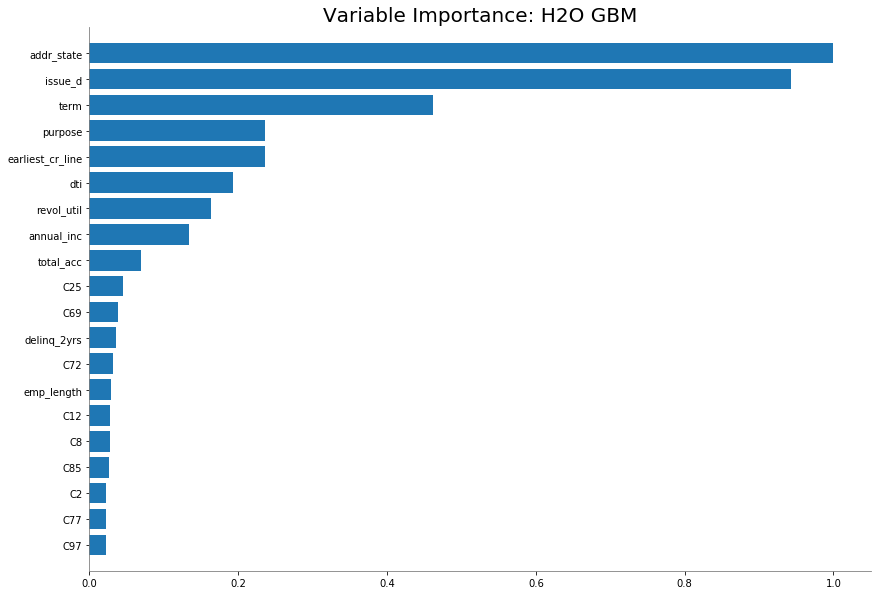

In [36]:
gbm_word_embeddings.varimp_plot(num_of_features=20)

## Step 4. Perform Target Encoding on Categorical Features

From our original baseline model, we can see that the variable `addr_state` has very high importance. It is surprising that `addr_state` has such high variable importance. The high variable importance could be because our model is memorizing the training data through this high cardinality categorical column. See: [Best Practices - Categorical Predictors](https://github.com/h2oai/h2o-tutorials/tree/master/best-practices/categorical-predictors) for more information on why this occurs.

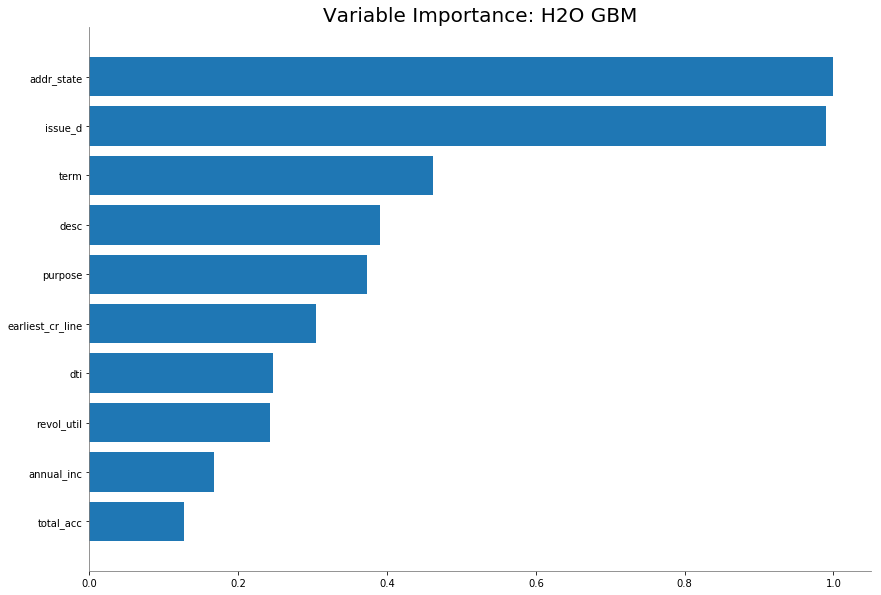

In [37]:
gbm_baseline.varimp_plot()

If we train our same GBM model without `addr_state` we actually see an improvement in model performance on the holdout data. This indicates that we are indeed overfitting on the high cardinality column.  

In [38]:
# Train GBM model without state

gbm_no_state = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_no-state.hex", 
                                            ntrees = 500, 
                                            stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                            stopping_metric = "AUC", 
                                            nfolds = 5 # 5-fold cross validation
                                           )
gbm_no_state.train(x = list(set(predictors) - set(["addr_state"])), y = target, training_frame = ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [39]:
print("AUC on CV - Word Embeddings: " + str(round(gbm_word_embeddings.auc(xval = True), 3)))
print("AUC on CV - No State: " + str(round(gbm_no_state.auc(xval = True), 3)))

AUC on CV - Word Embeddings: 0.721
AUC on CV - No State: 0.725


To prevent this overfitting, we can perform target encoding on the `addr_state` column and use that in place of the original categorical column.  Target encoding is a powerful method of converting a categorical column to numeric.  Target Encoding is the practice of replacing a categorical value with the mean of the response.  For example, we can replace NY in our dataset with the probability of default for the loans originating in NY.  

Note: Our `TargetEncoder` function includes many options to prevent overfitting.  We will use cross validation Target Encoding for this example.  For more information on Target Encoding, see our documentation: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html

In [40]:
# Add Fold Column for Target Encoding
ext_train["cv_fold_te"] = ext_train.kfold_column(n_folds = 5, seed = 54321)

In [41]:
from h2o.targetencoder import TargetEncoder

# Fit target encoding on training data
targetEncoder = TargetEncoder(x= ["addr_state", "purpose"], y = "bad_loan", fold_column = "cv_fold_te")
targetEncoder.fit(ext_train)

In [44]:
# Apply to train and test data
ext_train = targetEncoder.transform(frame=ext_train, 
                                    holdout_type="kfold", 
                                    seed=54321, 
                                    noise = 0
                                   )

ext_test = targetEncoder.transform(frame=ext_test, 
                                   holdout_type="none", # no need to do holdout because 
                                                        #target encoder was calculated on train
                                   seed=54321, 
                                   noise = 0
                                  )

Now for each Fold ID and `addr_state` we have a numeric value.  We will use the target encoding representation of `addr_state` instead of the original column in our next model.  We have done the same step for `purpose` which is another categorical feature with a high number of categories.

In [45]:
ext_train[["cv_fold_te", "addr_state", "addr_state_te", "purpose", "purpose_te"]]

cv_fold_te,addr_state,addr_state_te,purpose,purpose_te
0,AK,0.276596,car,0.145078
0,AL,0.195572,car,0.145078
0,AR,0.144828,car,0.145078
0,AZ,0.197441,car,0.145078
0,AZ,0.197441,car,0.145078
0,AZ,0.197441,car,0.145078
0,AZ,0.197441,car,0.145078
0,AZ,0.197441,car,0.145078
0,CA,0.20982,car,0.145078
0,CA,0.20982,car,0.145078


In [46]:
# Train GBM model using target encoding instead of state and purpose

predictors = list(set(ext_train.col_names) - set(["cv_fold_te", target, "desc", "addr_state", "purpose"]))

gbm_te = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_target-encoding.hex", 
                                      ntrees = 500, 
                                      stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                      stopping_metric = "AUC",
                                      nfolds = 5 # 5-fold cross validation
                                     )
gbm_te.train(x = predictors, y = target, training_frame = ext_train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


By adding the target encoding of `addr_state` and `purpose` and removing the original high cardinality features from the predictors, we have very similar performance to the model where we removed `addr_state` completely.  This could indicate that the state and purpose of the loan is not very informative in predicting whether or not a loan will be fully paid off.

In [47]:
print("AUC on CV - Word Embeddings: " + str(round(gbm_word_embeddings.auc(xval = True), 3)))
print("AUC on CV - No State: " + str(round(gbm_no_state.auc(xval = True), 3)))
print("AUC on CV - Target Encoding: " + str(round(gbm_te.auc(xval = True), 3)))

AUC on CV - Word Embeddings: 0.721
AUC on CV - No State: 0.725
AUC on CV - Target Encoding: 0.725


The variable `addr_state_te` has much smaller variable importance than the original `addr_state`.  This indicates that the model is no longer overfitting on `addr_state` information.

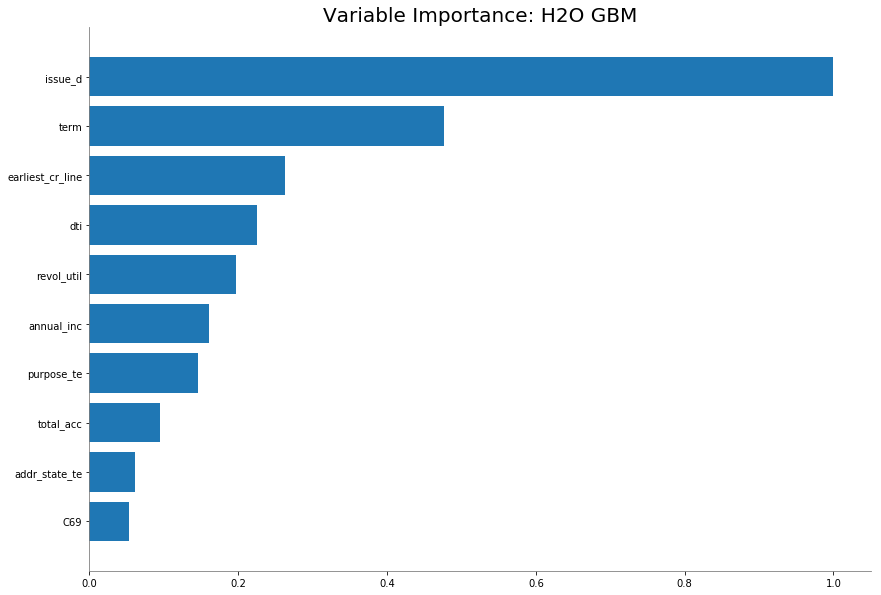

In [48]:
gbm_te.varimp_plot()

## Step 5. Add Anomaly Score

We can also use unsupervised learning models to add interesting information about the data.  For example: 

* what are the natural segments found in the data
* which records are strange

In this step, we will use the Isolation Forest algorithm to add an anomaly score to each record.  We will see if this information improves the model performance.

In [49]:
# Train Isolation Forest

from h2o.estimators import H2OIsolationForestEstimator

isolation_forest = H2OIsolationForestEstimator(seed = 1234,
                                               model_id = "isolation_forest.hex"
                                              )
isolation_forest.train(training_frame = ext_train, x = predictors)

isolationforest Model Build progress: |███████████████████████████████████| 100%


When you predict with isolation forest, the output is `predict` and `mean_length`.  The `mean_length` value is the average number of splits it takes to segment the record in a randomized tree.  The more splits it takes, the less likely the record is an anomaly.

The `predict` value is the `mean_length` normalized between 0 and 1.  Note: there may be some values less than 0 or greater than 1.  This because the current implementation calculates the min and max for normalization on a sample of the records.

In [50]:
isolation_forest.predict(ext_train)

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
-0.0308642,6.96
-0.037037,6.98
-0.037037,6.98
0.0123457,6.82
0.160494,6.34
-0.0308642,6.96
0.0432099,6.72
0.117284,6.48
0.00617284,6.84
0,6.86


We will add the normalized Isolation Forest prediction to our training and testing data.

In [51]:
# Add Isolation Forest scores to train 
anomaly_scores_train = isolation_forest.predict(ext_train)["predict"]
anomaly_scores_train.col_names = ["AnomalyScore"]
ext_train = ext_train.cbind(anomaly_scores_train)

isolationforest prediction progress: |████████████████████████████████████| 100%


In [ ]:
# Add Isolation Forest scores to test 
anomaly_scores_test = isolation_forest.predict(ext_test)["predict"]
anomaly_scores_test.col_names = ["AnomalyScore"]
ext_test = ext_test.cbind(anomaly_scores_test)

isolationforest prediction progress: |████████████████████████████████████| 100%


In [ ]:
# Train GBM model with anomaly score as new feature

predictors = list(set(ext_train.col_names) - set(["cv_fold_te", target, "desc", "addr_state", "purpose", 
                                                 "addr_state_te", "purpose_te"]))

gbm_anomaly_score = H2OGradientBoostingEstimator(seed = 1234, model_id = "gbm_anomaly-scores.hex", 
                                                 ntrees = 500, 
                                                 stopping_rounds = 10, score_tree_interval = 5, # early stopping
                                                 stopping_metric = "AUC",
                                                 nfolds = 5 # 5-fold cross validation
                                                )
gbm_anomaly_score.train(x = predictors, y = target, training_frame = ext_train)

gbm Model Build progress: |██

In [ ]:
print("AUC on CV - Baseline: " + str(round(gbm_baseline.auc(xval = True), 3)))
print("AUC on CV - Target Encoding: " + str(round(gbm_te.auc(xval = True), 3)))
print("AUC on CV - Anomaly Score: " + str(round(gbm_anomaly_score.auc(xval = True), 3)))

## Step 6. Evaluate Improvement to Model

Now that we have completed our feature engineering, we will evaluate how the model performs on our test data.

In [ ]:
print("AUC on CV - Baseline: " + str(round(gbm_baseline.auc(xval = True), 4)))
print("AUC on CV - with Anomaly Score: " + str(round(gbm_anomaly_score.auc(xval = True), 4)))

In [ ]:
print("AUC on Test - Baseline: " + str(round(gbm_baseline.model_performance(ext_test).auc(), 4)))
print("AUC on Test - with Anomaly Score: " + str(round(gbm_anomaly_score.model_performance(ext_test).auc(), 4)))

Our final model does significantly better on the test data.

## Step 7. Analyze Final Model

Our last step is to analyze our final model.

The `issue_d` has the greatest importance.  We can use the partial dependency plot to understand the relationship between `issue_d` and the probability of default.

In [ ]:
gbm_anomaly_score.varimp_plot()

In [ ]:
%matplotlib inline
pdp = gbm_anomaly_score.partial_plot(data=ext_train, cols = ["issue_d"])

The partial dependency plot for `issue_d` shows that there is a significant decrease in probability of loan default over time.  

This variable is the most important feature.  The GBM model may extrapolate into the future so removing this variable should be considered.

In [ ]:
h2o.cluster().shutdown()